In [14]:
import torch
print(f"PyTorch version: {torch.__version__}")


PyTorch version: 2.0.1+cu117


In [15]:
import torch
print(torch.version.cuda)


11.7


In [16]:
!nvidia-smi

Tue Nov 19 23:34:41 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 561.09                 Driver Version: 561.09         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060 ...  WDDM  |   00000000:01:00.0  On |                  N/A |
| N/A   39C    P8             17W /   95W |    3445MiB /   6144MiB |     16%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [18]:
import csv
import os

import numpy as np
import pandas as pd
from epiweeks import Week

from data_downloader import GenerateTrainingData
from utils import date_today, gravity_law_commute_dist

os.environ['NUMEXPR_MAX_THREADS'] = '16'
os.environ['NUMEXPR_NUM_THREADS'] = '8'

import pickle
import matplotlib.pyplot as plt
import dgl
import torch
from torch import nn
import torch.nn.functional as F
from model import STAN

import sklearn
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

FileNotFoundError: Cannot find DGL C++ graphbolt library at c:\Users\ajaoo\miniconda3\envs\icu-demand-forecasting\lib\site-packages\dgl\graphbolt\graphbolt_pytorch_2.0.1.dll

In [ ]:
!pi

In [ ]:
GenerateTrainingData().download_jhu_data('2020-05-01', '2020-12-01')

Finish download


,state,latitude,longitude,fips,date_today,confirmed,deaths,recovered,active,hospitalization,new_cases
0,Alabama,32.3182,-86.9023,1.0,2020-05-03,7977,290,0.0,7687.0,12.0,277
0,Alabama,32.3182,-86.9023,1.0,2020-05-04,8203,298,0.0,7905.0,29.0,226
0,Alabama,32.3182,-86.9023,1.0,2020-05-05,8520,315,391.0,198.0,43.0,317
0,Alabama,32.3182,-86.9023,1.0,2020-05-06,8769,343,405.0,192.0,51.0,249
0,Alabama,32.3182,-86.9023,1.0,2020-05-07,9115,369,409.0,215.0,20.0,346
...,...,...,...,...,...,...,...,...,...,...,...
57,Wyoming,42.7560,-107.3025,56.0,2020-11-27,31773,215,21700.0,9858.0,0.0,1012
57,Wyoming,42.7560,-107.3025,56.0,2020-11-28,31928,215,22798.0,8915.0,0.0,155
57,Wyoming,42.7560,-107.3025,56.0,2020-11-29,32489,215,23022.0,9252.0,0.0,561
57,Wyoming,42.7560,-107.3025,56.0,2020-11-30,33305,215,24478.0,8612.0,0.0,816


In [ ]:
#Merge population data with downloaded data
raw_data = pickle.load(open('./data/state_covid_data.pickle','rb'))
pop_data = pd.read_csv('./uszips.csv')
pop_data = pop_data.groupby('state_name').agg({'population':'sum', 'density':'mean', 'lat':'mean', 'lng':'mean'}).reset_index()
raw_data = pd.merge(raw_data, pop_data, how='inner', left_on='state', right_on='state_name')

In [ ]:
pop_data

,state_name,population,density,lat,lng
0,Alabama,4864630,139.010903,32.884042,-86.819800
1,Alaska,737979,88.192437,61.656278,-153.337221
2,Arizona,6949259,447.967160,33.705827,-111.575755
3,Arkansas,2990472,80.360237,35.134413,-92.377327
4,California,39140219,1257.655082,36.425895,-119.922270
5,Colorado,5531233,377.471810,39.233229,-105.345361
6,Connecticut,3581504,621.263830,41.576424,-72.766440
7,Delaware,949495,686.301493,39.208012,-75.517384
8,District of Columbia,684390,4654.840385,38.900708,-77.026287
9,Florida,20596370,755.857375,28.162979,-82.025801


In [ ]:
# Generate location similarity
loc_list = list(raw_data['state'].unique())
loc_dist_map = {}

for each_loc in loc_list:
    loc_dist_map[each_loc] = {}
    for each_loc2 in loc_list:
        lat1 = raw_data[raw_data['state']==each_loc]['latitude'].unique()[0]
        lng1 = raw_data[raw_data['state']==each_loc]['longitude'].unique()[0]
        pop1 = raw_data[raw_data['state']==each_loc]['population'].unique()[0]
        
        lat2 = raw_data[raw_data['state']==each_loc2]['latitude'].unique()[0]
        lng2 = raw_data[raw_data['state']==each_loc2]['longitude'].unique()[0]
        pop2 = raw_data[raw_data['state']==each_loc2]['population'].unique()[0]
        
        loc_dist_map[each_loc][each_loc2] = gravity_law_commute_dist(lat1, lng1, pop1, lat2, lng2, pop2, r=0.5)

In [ ]:
loc_dist_map

NameError: name 'loc_dist_map' is not defined

In [ ]:
num_locations = len(loc_list)
print(f"Number of unique locations: {num_locations}")

NameError: name 'loc_dist_map' is not defined

In [ ]:
#Generate Graph
dist_threshold = 18

for each_loc in loc_dist_map:
    loc_dist_map[each_loc] = {k: v for k, v in sorted(loc_dist_map[each_loc].items(), key=lambda item: item[1], reverse=True)}
    
adj_map = {}
for each_loc in loc_dist_map:
    adj_map[each_loc] = []
    for i, each_loc2 in enumerate(loc_dist_map[each_loc]):
        if loc_dist_map[each_loc][each_loc2] > dist_threshold:
            if i <= 3:
                adj_map[each_loc].append(each_loc2)
            else:
                break
        else:
            if i <= 1:
                adj_map[each_loc].append(each_loc2)
            else:
                break

rows = []
cols = []
for each_loc in adj_map:
    for each_loc2 in adj_map[each_loc]:
        rows.append(loc_list.index(each_loc))
        cols.append(loc_list.index(each_loc2))

In [ ]:
loc_dist_map['Alabama']

{'Alabama': 99999.99999999999,
 'South Carolina': 108.59741605206139,
 'Louisiana': 48.38728880945531,
 'Kentucky': 22.510764001960286,
 'Minnesota': 14.205549978976938,
 'Colorado': 13.82894158236376,
 'Wisconsin': 10.795427380999408,
 'Oklahoma': 9.074260314573179,
 'Maryland': 8.964416519381071,
 'Oregon': 8.844877384003981,
 'Missouri': 8.675656313241515,
 'Tennessee': 6.516674814297488,
 'Indiana': 6.247420986106947,
 'Connecticut': 6.045271677836252,
 'Massachusetts': 5.216787377396814,
 'Arizona': 4.698396259434448,
 'Puerto Rico': 4.657146487291393,
 'Iowa': 4.412319481592568,
 'Mississippi': 4.39199642762415,
 'Arkansas': 4.258127278021843,
 'Kansas': 3.821623789726329,
 'Washington': 3.7263666616973925,
 'Utah': 3.6852680669627205,
 'Virginia': 3.4453625864353064,
 'Nevada': 3.2627883290907578,
 'New Jersey': 2.99873381795453,
 'Georgia': 2.668008093270385,
 'North Carolina': 2.604392803968267,
 'Michigan': 2.5503809397192154,
 'New Mexico': 2.2078808084657666,
 'Ohio': 2.134

In [ ]:
g = dgl.graph((rows, cols))

AttributeError: module 'dgl' has no attribute 'graph'

In [ ]:
#Preprocess features

active_cases = []
confirmed_cases = []
new_cases = []
death_cases = []
static_feat = []

for i, each_loc in enumerate(loc_list):
    active_cases.append(raw_data[raw_data['state'] == each_loc]['active'])
    confirmed_cases.append(raw_data[raw_data['state'] == each_loc]['confirmed'])
    new_cases.append(raw_data[raw_data['state'] == each_loc]['new_cases'])
    death_cases.append(raw_data[raw_data['state'] == each_loc]['deaths'])
    static_feat.append(np.array(raw_data[raw_data['state'] == each_loc][['population','density','lng','lat']]))
    
active_cases = np.array(active_cases)
confirmed_cases = np.array(confirmed_cases)
death_cases = np.array(death_cases)
new_cases = np.array(new_cases)
static_feat = np.array(static_feat)[:, 0, :]
recovered_cases = confirmed_cases - active_cases - death_cases
susceptible_cases = np.expand_dims(static_feat[:, 0], -1) - active_cases - recovered_cases

# Batch_feat: new_cases(dI), dR, dS
#dI = np.array(new_cases)
dI = np.concatenate((np.zeros((active_cases.shape[0],1), dtype=np.float32), np.diff(active_cases)), axis=-1)
dR = np.concatenate((np.zeros((recovered_cases.shape[0],1), dtype=np.float32), np.diff(recovered_cases)), axis=-1)
dS = np.concatenate((np.zeros((susceptible_cases.shape[0],1), dtype=np.float32), np.diff(susceptible_cases)), axis=-1)

In [ ]:
dR

array([[0.000e+00, 0.000e+00, 8.007e+03, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [0.000e+00, 1.000e+00, 1.400e+01, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [0.000e+00, 3.500e+01, 3.900e+01, ..., 5.780e+02, 5.270e+02,
        5.880e+02],
       ...,
       [0.000e+00, 0.000e+00, 1.900e+01, ..., 5.020e+02, 4.220e+02,
        8.190e+02],
       [0.000e+00, 2.500e+02, 1.580e+02, ..., 4.668e+03, 3.648e+03,
        4.340e+03],
       [0.000e+00, 0.000e+00, 1.400e+01, ..., 2.240e+02, 1.456e+03,
        1.525e+03]])

In [ ]:
#Build normalizer
normalizer = {'S':{}, 'I':{}, 'R':{}, 'dS':{}, 'dI':{}, 'dR':{}}

for i, each_loc in enumerate(loc_list):
    normalizer['S'][each_loc] = (np.mean(susceptible_cases[i]), np.std(susceptible_cases[i]))
    normalizer['I'][each_loc] = (np.mean(active_cases[i]), np.std(active_cases[i]))
    normalizer['R'][each_loc] = (np.mean(recovered_cases[i]), np.std(recovered_cases[i]))
    normalizer['dI'][each_loc] = (np.mean(dI[i]), np.std(dI[i]))
    normalizer['dR'][each_loc] = (np.mean(dR[i]), np.std(dR[i]))
    normalizer['dS'][each_loc] = (np.mean(dS[i]), np.std(dS[i]))

In [ ]:
normalizer

{'S': {'Alabama': (4759029.751173709, 71167.74721304166),
  'Alaska': (730881.4835680751, 8226.040208832901),
  'Arizona': (6793526.305164319, 90914.51219403668),
  'Arkansas': (2932522.8732394367, 43435.91705978253),
  'California': (38577762.85446009, 344411.6100321278),
  'Colorado': (5457592.422535211, 58907.50238699691),
  'Connecticut': (3529485.5352112674, 17833.866882060942),
  'Delaware': (932989.4507042253, 7090.08432534675),
  'District of Columbia': (671850.2488262911, 3792.750329266508),
  'Florida': (20124997.75117371, 304091.5067699736),
  'Georgia': (10081885.96713615, 134790.09025702364),
  'Hawaii': (1414991.3286384977, 6242.78548451024),
  'Idaho': (1655817.7417840376, 27544.93535366438),
  'Illinois': (12571706.873239437, 158707.04389037227),
  'Indiana': (6537398.300469483, 76255.15785035763),
  'Iowa': (3062193.1502347416, 56587.04053286856),
  'Kansas': (2862237.0985915493, 39238.65271199116),
  'Kentucky': (4394318.201877934, 45438.738678639886),
  'Louisiana': 

In [ ]:
def prepare_data(data, sum_I, sum_R, history_window=5, pred_window=15, slide_step=5):
    # Data shape n_loc, timestep, n_feat
    # Reshape to n_loc, t, history_window*n_feat
    n_loc = data.shape[0]
    timestep = data.shape[1]
    n_feat = data.shape[2]
    
    x = []
    y_I = []
    y_R = []
    last_I = []
    last_R = []
    concat_I = []
    concat_R = []
    for i in range(0, timestep, slide_step):
        if i+history_window+pred_window-1 >= timestep or i+history_window >= timestep:
            break
        x.append(data[:, i:i+history_window, :].reshape((n_loc, history_window*n_feat)))
        
        concat_I.append(data[:, i+history_window-1, 0])
        concat_R.append(data[:, i+history_window-1, 1])
        last_I.append(sum_I[:, i+history_window-1])
        last_R.append(sum_R[:, i+history_window-1])

        y_I.append(data[:, i+history_window:i+history_window+pred_window, 0])
        y_R.append(data[:, i+history_window:i+history_window+pred_window, 1])

    x = np.array(x, dtype=np.float32).transpose((1, 0, 2))
    last_I = np.array(last_I, dtype=np.float32).transpose((1, 0))
    last_R = np.array(last_R, dtype=np.float32).transpose((1, 0))
    concat_I = np.array(concat_I, dtype=np.float32).transpose((1, 0))
    concat_R = np.array(concat_R, dtype=np.float32).transpose((1, 0))
    y_I = np.array(y_I, dtype=np.float32).transpose((1, 0, 2))
    y_R = np.array(y_R, dtype=np.float32).transpose((1, 0, 2))
    return x, last_I, last_R, concat_I, concat_R, y_I, y_R

In [ ]:
valid_window = 25
test_window = 25

history_window=6
pred_window=15
slide_step=5

normalize = True

dynamic_feat = np.concatenate((np.expand_dims(dI, axis=-1), np.expand_dims(dR, axis=-1), np.expand_dims(dS, axis=-1)), axis=-1)
    
#Normalize
if normalize:
    for i, each_loc in enumerate(loc_list):
        dynamic_feat[i, :, 0] = (dynamic_feat[i, :, 0] - normalizer['dI'][each_loc][0]) / normalizer['dI'][each_loc][1]
        dynamic_feat[i, :, 1] = (dynamic_feat[i, :, 1] - normalizer['dR'][each_loc][0]) / normalizer['dR'][each_loc][1]
        dynamic_feat[i, :, 2] = (dynamic_feat[i, :, 2] - normalizer['dS'][each_loc][0]) / normalizer['dS'][each_loc][1]

dI_mean = []
dI_std = []
dR_mean = []
dR_std = []

for i, each_loc in enumerate(loc_list):
    dI_mean.append(normalizer['dI'][each_loc][0])
    dR_mean.append(normalizer['dR'][each_loc][0])
    dI_std.append(normalizer['dI'][each_loc][1])
    dR_std.append(normalizer['dR'][each_loc][1])

dI_mean = np.array(dI_mean)
dI_std = np.array(dI_std)
dR_mean = np.array(dR_mean)
dR_std = np.array(dR_std)

#Split train-test
train_feat = dynamic_feat[:, :-valid_window-test_window, :]
val_feat = dynamic_feat[:, -valid_window-test_window:-test_window, :]
test_feat = dynamic_feat[:, -test_window:, :]

train_x, train_I, train_R, train_cI, train_cR, train_yI, train_yR = prepare_data(train_feat, active_cases[:, :-valid_window-test_window], recovered_cases[:, :-valid_window-test_window], history_window, pred_window, slide_step)
val_x, val_I, val_R, val_cI, val_cR, val_yI, val_yR = prepare_data(val_feat, active_cases[:, -valid_window-test_window:-test_window], recovered_cases[:, -valid_window-test_window:-test_window], history_window, pred_window, slide_step)
test_x, test_I, test_R, test_cI, test_cR, test_yI, test_yR = prepare_data(test_feat, active_cases[:, -test_window:], recovered_cases[:, -test_window:], history_window, pred_window, slide_step)

In [ ]:
#Build STAN model

in_dim = 3*history_window
hidden_dim1 = 32
hidden_dim2 = 32
gru_dim = 32
num_heads = 1
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

g = g.to(device)
model = STAN(g, in_dim, hidden_dim1, hidden_dim2, gru_dim, num_heads, pred_window, device).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
criterion = nn.MSELoss()

In [ ]:
model

STAN(
  (layer1): MultiHeadGATLayer(
    (heads): ModuleList(
      (0): GATLayer(
        (fc): Linear(in_features=18, out_features=32, bias=True)
        (attn_fc): Linear(in_features=64, out_features=1, bias=True)
      )
    )
  )
  (layer2): MultiHeadGATLayer(
    (heads): ModuleList(
      (0): GATLayer(
        (fc): Linear(in_features=32, out_features=32, bias=True)
        (attn_fc): Linear(in_features=64, out_features=1, bias=True)
      )
    )
  )
  (gru): GRUCell(32, 32)
  (nn_res_I): Linear(in_features=34, out_features=15, bias=True)
  (nn_res_R): Linear(in_features=34, out_features=15, bias=True)
  (nn_res_sir): Linear(in_features=34, out_features=2, bias=True)
)

In [ ]:
train_x = torch.tensor(train_x).to(device)
train_I = torch.tensor(train_I).to(device)
train_R = torch.tensor(train_R).to(device)
train_cI = torch.tensor(train_cI).to(device)
train_cR = torch.tensor(train_cR).to(device)
train_yI = torch.tensor(train_yI).to(device)
train_yR = torch.tensor(train_yR).to(device)

val_x = torch.tensor(val_x).to(device)
val_I = torch.tensor(val_I).to(device)
val_R = torch.tensor(val_R).to(device)
val_cI = torch.tensor(val_cI).to(device)
val_cR = torch.tensor(val_cR).to(device)
val_yI = torch.tensor(val_yI).to(device)
val_yR = torch.tensor(val_yR).to(device)

test_x = torch.tensor(test_x).to(device)
test_I = torch.tensor(test_I).to(device)
test_R = torch.tensor(test_R).to(device)
test_cI = torch.tensor(test_cI).to(device)
test_cR = torch.tensor(test_cR).to(device)
test_yI = torch.tensor(test_yI).to(device)
test_yR = torch.tensor(test_yR).to(device)

dI_mean = torch.tensor(dI_mean, dtype=torch.float32).to(device).reshape((dI_mean.shape[0], 1, 1))
dI_std = torch.tensor(dI_std, dtype=torch.float32).to(device).reshape((dI_mean.shape[0], 1, 1))
dR_mean = torch.tensor(dR_mean, dtype=torch.float32).to(device).reshape((dI_mean.shape[0], 1, 1))
dR_std = torch.tensor(dR_std, dtype=torch.float32).to(device).reshape((dI_mean.shape[0], 1, 1))

N = torch.tensor(static_feat[:, 0], dtype=torch.float32).to(device).unsqueeze(-1)

In [ ]:
#Train STAN

all_loss = []
file_name = './save/stan'
min_loss = 1e10

loc_name = 'California'
cur_loc = loc_list.index(loc_name)

epoch = 50 if normalize else 300
scale = 0.1

for epoch in tqdm(range(epoch)):
    model.train()
    optimizer.zero_grad()
    
    active_pred, recovered_pred, phy_active, phy_recover, _ = model(train_x, train_cI[cur_loc], train_cR[cur_loc], N[cur_loc], train_I[cur_loc], train_R[cur_loc])
    if normalize:
        phy_active = (phy_active - dI_mean[cur_loc]) / dI_std[cur_loc]
        phy_recover = (phy_recover - dR_mean[cur_loc]) / dR_std[cur_loc]
    loss = criterion(active_pred.squeeze(), train_yI[cur_loc].squeeze())+criterion(recovered_pred.squeeze(), train_yR[cur_loc].squeeze())+scale*criterion(phy_active.squeeze(), train_yI[cur_loc].squeeze()) + scale*criterion(phy_recover.squeeze(), train_yR[cur_loc].squeeze())
    
    loss.backward()
    optimizer.step()
    all_loss.append(loss.item())
    
    model.eval()
    _, _, _, _, prev_h = model(train_x, train_cI[cur_loc], train_cR[cur_loc], N[cur_loc], train_I[cur_loc], train_R[cur_loc])
    val_active_pred, val_recovered_pred, val_phy_active, val_phy_recover, _ = model(val_x, val_cI[cur_loc], val_cR[cur_loc], N[cur_loc], val_I[cur_loc], val_R[cur_loc], prev_h)
    
    if normalize:
        val_phy_active = (val_phy_active - dI_mean[cur_loc]) / dI_std[cur_loc]
    val_loss = criterion(val_active_pred.squeeze(), val_yI[cur_loc].squeeze()) + scale*criterion(val_phy_active.squeeze(), val_yI[cur_loc].squeeze())
    if val_loss < min_loss:    
        state = {
            'state': model.state_dict(),
            'optimizer': optimizer.state_dict(),
        }
        torch.save(state, file_name)
        min_loss = val_loss


100%|██████████| 50/50 [01:41<00:00,  2.03s/it]


In [ ]:
#Pred with STAN
file_name = './save/stan'
checkpoint = torch.load(file_name)
model.load_state_dict(checkpoint['state'])
optimizer.load_state_dict(checkpoint['optimizer'])
model.eval()


prev_x = torch.cat((train_x, val_x), dim=1)
prev_I = torch.cat((train_I, val_I), dim=1)
prev_R = torch.cat((train_R, val_R), dim=1)
prev_cI = torch.cat((train_cI, val_cI), dim=1)
prev_cR = torch.cat((train_cR, val_cR), dim=1)
prev_active_pred, _, prev_phyactive_pred, _, h = model(prev_x, prev_cI[cur_loc], prev_cR[cur_loc], N[cur_loc], prev_I[cur_loc], prev_R[cur_loc])


test_pred_active, test_pred_recovered, test_pred_phy_active, test_pred_phy_recover, _ = model(test_x, test_cI[cur_loc], test_cR[cur_loc], N[cur_loc], test_I[cur_loc], test_R[cur_loc], h)


In [ ]:
if normalize:
    print('Estimated beta in SIR model is %.2f'%model.alpha_scaled)
    print('Estimated gamma in SIR model is %.2f'%model.beta_scaled)

Estimated beta in SIR model is 0.75
Estimated gamma in SIR model is 0.82


In [ ]:
#Cumulate predicted dI
pred_I = []

for i in range(test_pred_active.size(1)):
    if normalize:
        cur_pred = (test_pred_active[0, i, :].detach().cpu().numpy() * dI_std[cur_loc].reshape(1, 1).detach().cpu().numpy()) + dI_mean[cur_loc].reshape(1, 1).detach().cpu().numpy()
    else:
        cur_pred = test_pred_active[0, i, :].detach().cpu().numpy()
    cur_pred = np.cumsum(cur_pred)
    cur_pred = cur_pred + test_I[cur_loc, i].detach().cpu().item()
    pred_I.append(cur_pred)
pred_I = np.array(pred_I)
pred_I = pred_I

In [ ]:
def get_real_y(data, history_window=5, pred_window=15, slide_step=5):
    # Data shape n_loc, timestep, n_feat
    # Reshape to n_loc, t, history_window*n_feat
    n_loc = data.shape[0]
    timestep = data.shape[1]
    
    y = []
    for i in range(0, timestep, slide_step):
        if i+history_window+pred_window-1 >= timestep or i+history_window >= timestep:
            break
        y.append(data[:, i+history_window:i+history_window+pred_window])
    y = np.array(y, dtype=np.float32).transpose((1, 0, 2))
    return y

In [ ]:
I_true = get_real_y(active_cases[:], history_window, pred_window, slide_step)

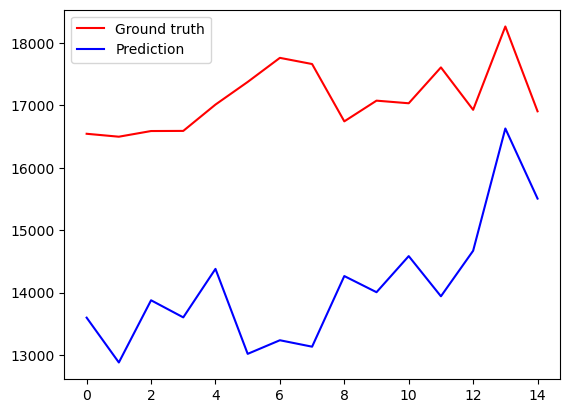

In [ ]:
plt.plot(I_true[cur_loc, -1, :],c='r', label='Ground truth')
plt.plot(pred_I[-1, :],c='b', label='Prediction')
plt.legend()
plt.show()